# Setup

Install the dependencies:
```sh
pip install gym
pip install gym[atari]
```

# Useful Resources
* [Manual of the game](https://www.gamesdatabase.org/Media/SYSTEM/Atari_2600/Manual/formated/Freeway_-_1981_-_Zellers.pdf)
* [Freeway Disassembly](http://www.bjars.com/disassemblies.html)
* [Atari Ram Annotations](https://github.com/mila-iqia/atari-representation-learning/blob/master/atariari/benchmark/ram_annotations.py)
* [Freeway Benchmarks](https://paperswithcode.com/sota/atari-games-on-atari-2600-freeway)

# Description of the problem

TODO

# Imports

In [ ]:
import sys
sys.path.append('../')  # Enable importing from `src` folder

In [2]:
%matplotlib inline
from collections import defaultdict
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots

In [3]:
def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

# Environment

We will be using the Open AI Gym framework in this study.......

In [4]:
# env, initial_state = environment.get_env()

# print("Action Space:", env.action_space)
# print("Observation Space:", env.observation_space)

The agent in this game has three possible actions:

* 0: Stay
* 1: Move forward
* 2: Move back

TODO: Talk a bit about the observation space of 128 bytes of RAM...

# Baseline

As a simple baseline, we are using an agent that moves always **up**.

In [5]:
# scores = environment.run(agents.Baseline, render=True, n_runs=1)

In [6]:
# Mean score
# print("Mean score:", sum(scores) / len(scores))

It usually scores from 21 to 23 points, as shown in the images below:

![Baseline 1](./img/baseline_1.png)
![Baseline 2](./img/baseline_2.png)

# Representing the state of the game

TODO: explain why we must reduce the state space

```
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 18  # Chicken Collision flag (with the bottom car)
    , 22  # Car X Direction
    , 23, 24, 25, 26, 27, 28, 29, 30, 31, 32  # Z Car Patterns
    , 33, 34, 35, 36, 37, 38, 39, 40, 41, 42  # Car Motion Timmers
    , 43, 44, 45, 46, 47, 48, 49, 50, 51, 52  # Car Motions
    , 87, 88  # Car Shape Ptr
    # TODO: test if this makes any difference
    , 89, 90  # Chicken Shape Ptr
    # TODO: test if this makes any difference
    , 106, 107  # Chicken Sounds
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
```

In [7]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

In [8]:
def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 20 or ob[b] > 80:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space
            ob[b] = ob[b] // 3

    return ob

# Reward Policy

In [9]:
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
    elif action != 1:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL

    return reward

# Hyper Parameters

In [10]:
GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 = 2.5
LAMBD = 0.2

reward_policy.REWARD_IF_CROSS = 50
reward_policy.REWARD_IF_COLISION = -1
reward_policy.REWARD_IF_STILL = -0.1

# SARSA(λ)

In [11]:
class SarsaLambda():  ## ADD THE AGENT
    def __init__(self, gamma: float, available_actions: int, N0: float, lambd: float):
        self.gamma = gamma
        self.available_actions = available_actions
        self.N0 = N0
        self.lambd = lambd

        self.Q = defaultdict(lambda: np.zeros(self.available_actions))
        self.state_visits = defaultdict(lambda: 0)
        self.Nsa = defaultdict(lambda: defaultdict(lambda: 0))

    def act(self, state):
        epsilon = self.N0 / (self.N0 + self.state_visits[state])

        if np.random.choice(np.arange(self.available_actions), p=[1 - epsilon, epsilon]):
            action = np.random.choice(self.available_actions)  # Explore!
        elif self.Q[state].max() == 0.0 and self.Q[state].min() == 0.0:
            action = 1  # Bias toward going forward
        else:
            action = self.Q[state].argmax()  # Greedy action

        self.state_visits[state] += 1

        self.Nsa[state][action] += 1

        return action

    def update_Q(self, old_s, new_s, old_a, new_a, reward, E):
        delta = reward + self.gamma * self.Q[new_s][new_a] - self.Q[old_s][old_a]
        alpha = (1 / self.Nsa[old_s][old_a])

        for s, A in E.items():
            for a in range(len(A)):
                self.Q[old_s][old_a] = self.Q[old_s][old_a] + alpha * delta * E[s][a]
                E[s][a] = self.gamma * self.lambd * E[s][a]
#                 print(s, a)

#         self.Q[old_s][old_a] = (self.Q[old_s][old_a] +
#                                      alpha * (reward + (self.gamma * self.Q[new_s].max()) - self.Q[old_s][old_a]))

In [12]:
env, initial_state = environment.get_env()

In [13]:
# agent = agents.SarsaLambda(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0, lambd=LAMBD)
agent = SarsaLambda(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0, lambd=LAMBD)

In [14]:
scores = []
total_rewards = []

In [15]:
%%time
n_runs = 1000

for i in range(n_runs):
    render = i % 200 == 199

    E = defaultdict(lambda: np.zeros(2)) # TODO available actions

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
    
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.005)
            env.render()

        old_state = state
        old_action = action
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        action = agent.act(state)  # Next action
        
        E[old_state][old_action] += 1

        agent.update_Q(old_s=old_state, new_s=state, old_a=old_action, new_a=action, reward=reward, E=E)

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

Run [   0] - Total reward:  343.90 Mean scores: 11.00 Means Scores[:-10]: 11.00 Score: 11 
Run [  10] - Total reward:  348.30 Mean scores: 11.36 Means Scores[:-10]: 11.40 Score: 11 
Run [  20] - Total reward:  538.00 Mean scores: 12.43 Means Scores[:-10]: 13.60 Score: 14 
Run [  30] - Total reward:  695.40 Mean scores: 12.90 Means Scores[:-10]: 13.90 Score: 17 
Run [  40] - Total reward:  581.20 Mean scores: 13.32 Means Scores[:-10]: 14.60 Score: 15 
Run [  50] - Total reward:  464.80 Mean scores: 13.59 Means Scores[:-10]: 14.70 Score: 13 
Run [  60] - Total reward:  529.10 Mean scores: 14.03 Means Scores[:-10]: 16.30 Score: 14 
Run [  70] - Total reward:  714.70 Mean scores: 14.45 Means Scores[:-10]: 17.00 Score: 17 
Run [  80] - Total reward:  797.50 Mean scores: 14.83 Means Scores[:-10]: 17.50 Score: 19 
Run [  90] - Total reward:  801.70 Mean scores: 15.26 Means Scores[:-10]: 18.80 Score: 19 
Run [ 100] - Total reward:  876.20 Mean scores: 15.55 Means Scores[:-10]: 18.20 Score: 20 

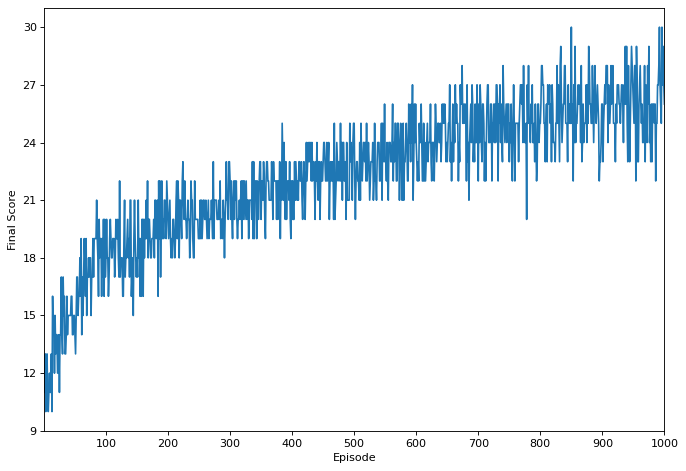

In [16]:
aux_plots.plot_scores(scores)

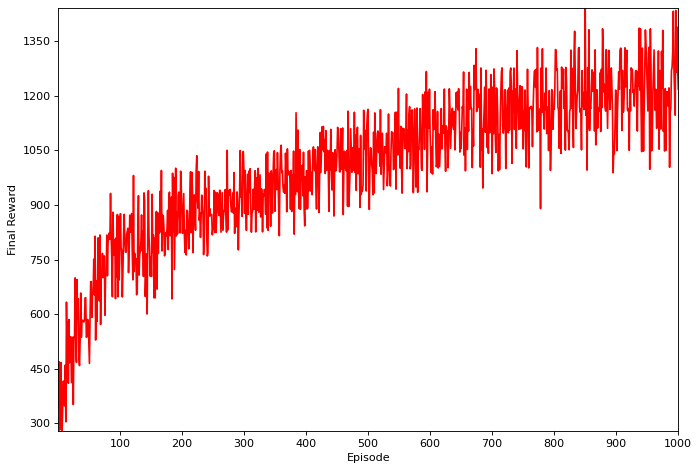

In [17]:
aux_plots.plot_rewards(total_rewards)

In [18]:
stop

NameError: name 'stop' is not defined

# Q-Learning

In [ ]:
env, initial_state = environment.get_env()

In [ ]:
agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

In [ ]:
scores = []
total_rewards = []

In [ ]:
%%time
n_runs = 1

for i in range(n_runs):
    render = i % 200 == 0

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)
    
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.025)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

In [ ]:
aux_plots.plot_scores(scores)

In [ ]:
aux_plots.plot_rewards(total_rewards)

In [ ]:
stop

# Monte Carlo Control

It usually scores from 21 to 23 points, as shown in the images below:

![Baseline 1](./img/baseline_1.png)
![Baseline 2](./img/baseline_2.png)

In [ ]:
env, initial_state = environment.get_env()

In [ ]:
agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

In [ ]:
def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_state, reward_policy=reward_policy, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

In [ ]:
%%time
MonteCarloES(RAM_mask=RAM_mask, render=False)

In [ ]:
scores = []
total_rewards = []

In [ ]:
%%time

n_runs = 2500

for i in range(n_runs):
    render = i % 201 == 200

    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

In [ ]:
aux_plots.plot_scores(scores)

In [ ]:
aux_plots.plot_rewards(total_rewards)

In [ ]:
stop